Program written by: Ningyou Li, 20307142; This program 

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pandas as pd
import sys
import nrrd
import os
%config Completer.use_jedi = False

In [2]:
# read image
img = sitk.ReadImage('Case11.mhd')
seg_img = sitk.ReadImage('Case11_segmentation.mhd')

In [3]:
def image_Info(image):
    """
    :param image: the input image read by SimpleITK
    :return: None
    This function prints the properties of the image. Properties include: size, spacing, origin, direction, pixel type
    """
    print('Size:', image.GetSize()) #size
    print('Space:', image.GetSpacing()) #space
    print('Origin:', image.GetOrigin()) #origin
    print('Direction:', image.GetDirection()) #direction
    print('Pixel Type:', image.GetPixelIDTypeAsString()) #pixel type
    
image_Info(img)

Size: (512, 512, 45)
Space: (0.312499, 0.312502, 2.79998)
Origin: (-99.4454, -77.9882, -58.7955)
Direction: (0.999637, -7.58933e-19, 0.0269276, 0.00448624, 0.986045, -0.166417, -0.0265512, 0.166477, 0.985688)
Pixel Type: 16-bit signed integer


In [10]:
# some information about pixels
stat_filter = sitk.StatisticsImageFilter()
stat_filter.Execute(img) #the output is not an image object but it has information
print('min pixel value: ',stat_filter.GetMinimum())
print('max pixel value: ',stat_filter.GetMaximum())

min pixel value:  0.0
max pixel value:  27479.0


In [68]:
image_Info(seg_img)

Size: (512, 512, 45)
Space: (0.312499, 0.312502, 2.79998)
Origin: (-99.4454, -77.9882, -58.7955)
Direction: (0.999637, -1.51787e-18, 0.0269276, 0.00448624, 0.986045, -0.166417, -0.0265512, 0.166477, 0.985688)
Pixel Type: 8-bit signed integer


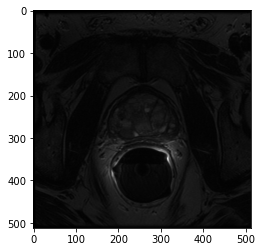

In [25]:
plt.imshow(sitk.GetArrayFromImage(img[:,:,22])) 

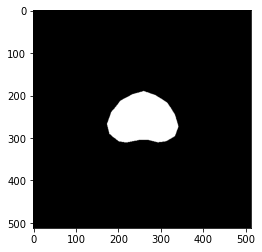

In [32]:
plt.imshow(sitk.GetArrayFromImage(seg_img[:,:,22])) 

In [18]:
# Set external viewer to 3D slicer and Open with external viewer
image_viewer = sitk.ImageViewer()
image_viewer.SetApplication('C:/Users/Linda/AppData/Local/NA-MIC/Slicer 4.11.20210226/Slicer.exe')
image_viewer.Execute(img)

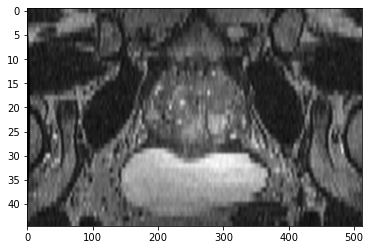

In [16]:
plt.imshow(sitk.GetArrayFromImage(img[:,256,:]),cmap='gray', aspect='auto') 

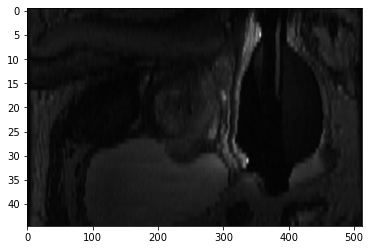

In [17]:
plt.imshow(sitk.GetArrayFromImage(img[256,:,:]),cmap='gray',aspect='auto') 

In [ ]:
def prostate_segmenter(image):
    

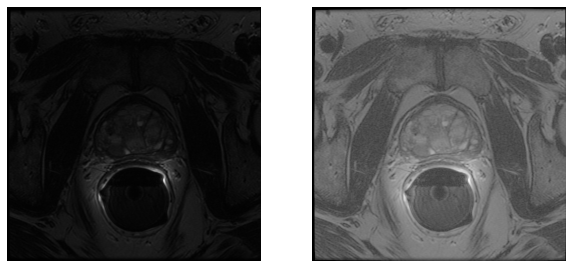

In [5]:
# gamma correction
img = sitk.Cast(img, sitk.sitkFloat32)
filtered_img = ((img/255)**0.3) # lambda<0, brighten the image: show more details in dark
gamma_img = sitk.RescaleIntensity(filtered_img,0,255)

plt.figure(figsize=(10,5))
plt.gray()
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(img[:,:,22]))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(gamma_img[:,:,22])) # vmax should be tunned based on the nature of the filtered image
plt.axis('off')
plt.show()

In [ ]:
hist_equal_filter = sitk.AdaptiveHistogramEqualizationImageFilter()
hist_equal_filter.SetAlpha(0.1)
hist_equal_filter.SetBeta(5.5)
hist_equal_filter.SetRadius(40)
equalied_img5 = hist_equal_filter.Execute(gamma_img)

# Show reference image and filtered images
#plt.figure(figsize=(20,10))
plt.subplot(121)
plt.gray()
plt.imshow(sitk.GetArrayFromImage(filtered_img[:,:,22] ))
plt.title('Reference')
plt.subplot(122)
plt.imshow(sitk.GetArrayFromImage(equalied_img5[:,:,22])) # vmax should be tunned based on the nature of the filtered image
plt.title('After Equalization')
plt.show()

In [19]:
image_viewer.Execute(equalied_img5)

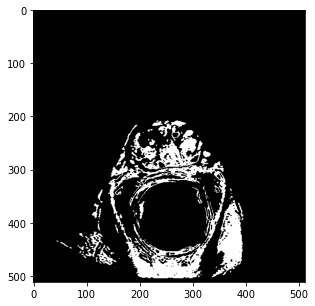

In [16]:
# Use region growing to segment the prostate
seed_pts = [(262,232,22)]
#F4:(425,4463,4);F3:(236,4837,4); F2:(329,4400,4);F1:(327,6519,4)
growing_filter = sitk.ConfidenceConnectedImageFilter()
# set seed
growing_filter.SetSeedList(seed_pts)
# set range of pixel intensity
growing_filter.SetMultiplier(1.5)
growing_filter.SetNumberOfIterations(2)
con_growed_img1 = growing_filter.Execute(equalied_img5)

plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(con_growed_img1[:,:,22]))

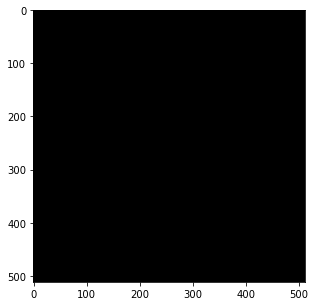

In [76]:
# Use ConnectedThresholdImageFilter() to grow region
ConnectedThresholdImageFilter = sitk.ConnectedThresholdImageFilter()
ConnectedThresholdImageFilter.SetLower(143)
# lower threshold tried: 0, 18, 30, 80, 90, 140
ConnectedThresholdImageFilter.SetUpper(185)
ConnectedThresholdImageFilter.SetSeedList([(262,232,22)]) 
# #F4:(425,4463,4);F3:(236,4837,4); F2:(329,4400,4);F1:(327,6519,4)

threshold_img = ConnectedThresholdImageFilter.Execute(equalied_img5)

plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(threshold_img[:,:,22]))

In [29]:
# if len(sys.argv) < 10:
#     print("Usage: {0} <inputImage> <outputImage> <seedX> <seedY> <Sigma> <SigmoidAlpha> <SigmoidBeta> <TimeThreshold>".format(sys.argv[0]))
#     sys.exit(1)

# inputFilename = sys.argv[1]
# outputFilename = sys.argv[2]

# seedPosition = (int(sys.argv[3]), int(sys.argv[4]))

# sigma = float(sys.argv[5])
# alpha = float(sys.argv[6])
# beta = float(sys.argv[7])
# timeThreshold = float(sys.argv[8])
# stoppingTime = float(sys.argv[9])

# #inputImage = sitk.ReadImage(inputFilename, sitk.sitkFloat32)

# print(inputImage)

smoothing = sitk.CurvatureAnisotropicDiffusionImageFilter()
smoothing.SetTimeStep(0.125)
smoothing.SetNumberOfIterations(5)
smoothing.SetConductanceParameter(9.0)
smoothingOutput = smoothing.Execute(img)

gradientMagnitude = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
gradientMagnitude.SetSigma(3)
gradientMagnitudeOutput = gradientMagnitude.Execute(smoothingOutput)

sigmoid = sitk.SigmoidImageFilter()
sigmoid.SetOutputMinimum(0.0)
sigmoid.SetOutputMaximum(1.0)
sigmoid.SetAlpha(0.2)
sigmoid.SetBeta(0.2)
sigmoid.DebugOn()
sigmoidOutput = sigmoid.Execute(gradientMagnitudeOutput)


fastMarching = sitk.FastMarchingImageFilter()

#seedValue = 0
#trialPoint = (seedPosition[0], seedPosition[1], seedValue)

seedPoint = (262,232,22)
fastMarching.AddTrialPoint(seedPoint)

fastMarching.SetStoppingValue(1000)

fastMarchingOutput = fastMarching.Execute(sigmoidOutput)


thresholder = sitk.BinaryThresholdImageFilter()
thresholder.SetLowerThreshold(0.0)
thresholder.SetUpperThreshold(135)
thresholder.SetOutsideValue(0)
thresholder.SetInsideValue(255)

result = thresholder.Execute(sigmoidOutput)


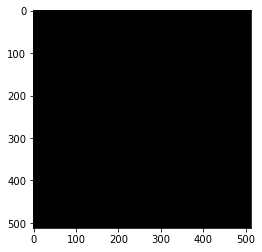

In [30]:
plt.imshow(sitk.GetArrayFromImage(result[:,:,22]))

117.54824829101562


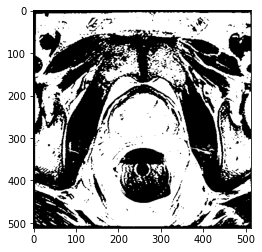

In [40]:
otsu_filter = sitk.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(0)
otsu_filter.SetOutsideValue(1)
seg = otsu_filter.Execute(gamma_img)
plt.imshow(sitk.GetArrayFromImage(seg[:,:,22]))
#plt.imshow(sitk.LabelOverlay(img[:,:,22], seg[:,:,22]), "Otsu Thresholding")
print(otsu_filter.GetThreshold())


# Part C


In [49]:
print((sitk.GetArrayFromImage(seg_img[:,:,22])))
segImage_array = sitk.GetArrayFromImage(seg_img[:,:,22])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [65]:
pixels = len(np.column_stack(np.where(segImage_array > 0)))
x = np.mean(np.where(segImage_array > 0)[0])
y = np.mean(np.where(segImage_array > 0)[1])
print(len(np.where(segImage_array == 0)[0]))
print(pixels)
print(np.column_stack(np.where(segImage_array == 0)))
print(segImage_array)
print(np.where(segImage_array > 0)[0])
print(np.where(segImage_array > 0)[1])
print(x,y)

246899
15245
[[  0   0]
 [  0   1]
 [  0   2]
 ...
 [511 509]
 [511 510]
 [511 511]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[190 190 191 ... 310 310 310]
[259 260 256 ... 293 294 295]
256.3413578222368 257.19580190226304


In [57]:
stat_filter = sitk.StatisticsImageFilter()
stat_filter.Execute(seg_img) #the output is not an image object but it has information
print('min pixel value: ',stat_filter.GetMinimum())
print('max pixel value: ',stat_filter.GetMaximum())

min pixel value:  0.0
max pixel value:  1.0


In [69]:
from shapely.geometry import Polygon

ModuleNotFoundError: No module named 'shapely'